# Project description
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.

## Download the data and prepare it for analysis

In [1]:
# Loading all the libraries
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
from functools import reduce
import sidetable as stb

In [2]:
# Load the data file into a DataFrame
data = pd.read_csv('games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
data_mis = data.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(data.isnull().sum()/len(data),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
Critic_Score,8578,51.3
Rating,6766,40.5
User_Score,6701,40.1
Year_of_Release,269,1.6
Name,2,0.0
Platform,0,0.0
Genre,2,0.0
NA_sales,0,0.0
EU_sales,0,0.0
JP_sales,0,0.0


## Problems with the data
* In `name` and `genre` columns there are 2 missing values and 1.6% of missing values in `year_of_release`
* In `User_Score` `Rating` `Critic_Score` there are more than 40% missing values
* `user_score` type needs to be changed to float
* Upper case letters in column names

# Prepare the data

In [6]:
# Changing column names to lower case letters
data.columns = data.columns.str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [7]:
#addresing the 'tbd' problem
len(data.query('user_score == "tbd"'))

2424

In [8]:
data[data['user_score'] == 'tbd']['year_of_release'].value_counts()

2009.0    405
2010.0    331
2008.0    326
2011.0    217
2002.0    192
2007.0    192
2006.0    124
2005.0    121
2004.0    107
2003.0     95
2001.0     82
2000.0     43
2015.0     38
2016.0     34
2012.0     24
2014.0     21
2013.0     15
1999.0      8
1997.0      1
Name: year_of_release, dtype: int64

In [9]:
#finding user_score mean
user_mean = data[(data.user_score.notna())&(data['user_score'] != 'tbd')]['user_score'].astype('float64').mean()
user_mean

7.1250461133070315

In [10]:
data.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [11]:
data.describe(include='object')

,name,platform,genre,user_score,rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


## working with missing values

In [12]:
data[['name', 'year_of_release']]

,name,year_of_release
0,Wii Sports,2006.0
1,Super Mario Bros.,1985.0
2,Mario Kart Wii,2008.0
3,Wii Sports Resort,2009.0
4,Pokemon Red/Pokemon Blue,1996.0
...,...,...
16710,Samurai Warriors: Sanada Maru,2016.0
16711,LMA Manager 2007,2006.0
16712,Haitaka no Psychedelica,2016.0
16713,Spirits & Spells,2003.0


In [13]:
data[data['genre'].isnull()]
#same rows of missing values for 'game' and 'genre' columns

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [14]:
# removing missing values of game and genre (same rows) their insignificant, probably error
data = data.dropna(subset = ['name'])

In [15]:
len(data[data['name'].isnull()])

0

In [84]:
dct = dict(pd.MultiIndex.from_frame(data[['name', 'year_of_release']]))

# Checking the first 10 keys
dict(list(dct.items())[0:10])

{'Wii Sports': 2006.0,
 'Super Mario Bros.': 1999.0,
 'Mario Kart Wii': 2008.0,
 'Wii Sports Resort': 2009.0,
 'Pokemon Red/Pokemon Blue': 1996.0,
 'Tetris': 1988.0,
 'New Super Mario Bros.': 2006.0,
 'Wii Play': 2006.0,
 'New Super Mario Bros. Wii': 2009.0,
 'Duck Hunt': 1984.0}

In [17]:
#filling Year_of_release column with mean values grouped by name
data['year_of_release'] = data.groupby(['name'])['year_of_release'].transform(lambda grp: grp.fillna(np.mean(grp)))

In [18]:
clean_data = data.copy()
clean_data['year_of_release'] = clean_data['year_of_release'].fillna(0).astype(int)

In [19]:
data.stb.freq(['platform'],style=True, cum_cols=False)

,platform,count,percent
0,PS2,"2,161",12.93%
1,DS,"2,151",12.87%
2,PS3,"1,331",7.96%
3,Wii,"1,320",7.90%
4,X360,"1,262",7.55%
5,PSP,"1,209",7.23%
6,PS,"1,197",7.16%
7,PC,974,5.83%
8,XB,824,4.93%
9,GBA,822,4.92%


## Calculating total sales

In [20]:
clean_data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E


In [21]:
clean_data['total_sales'] = clean_data[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
clean_data['total_sales']

0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: total_sales, Length: 16713, dtype: float64

# Analyze the data

## Look at how many games were released in different years. Is the data for every period significant?

In [22]:
year_df = clean_data[['year_of_release','name']].groupby(['year_of_release']).count().sort_values(by='year_of_release').reset_index()
year_df = year_df[year_df['year_of_release'] !=0] 
year_df

,year_of_release,name
1,1980,9
2,1981,46
3,1982,36
4,1983,17
5,1984,14
6,1985,14
7,1986,21
8,1987,16
9,1988,15
10,1989,17


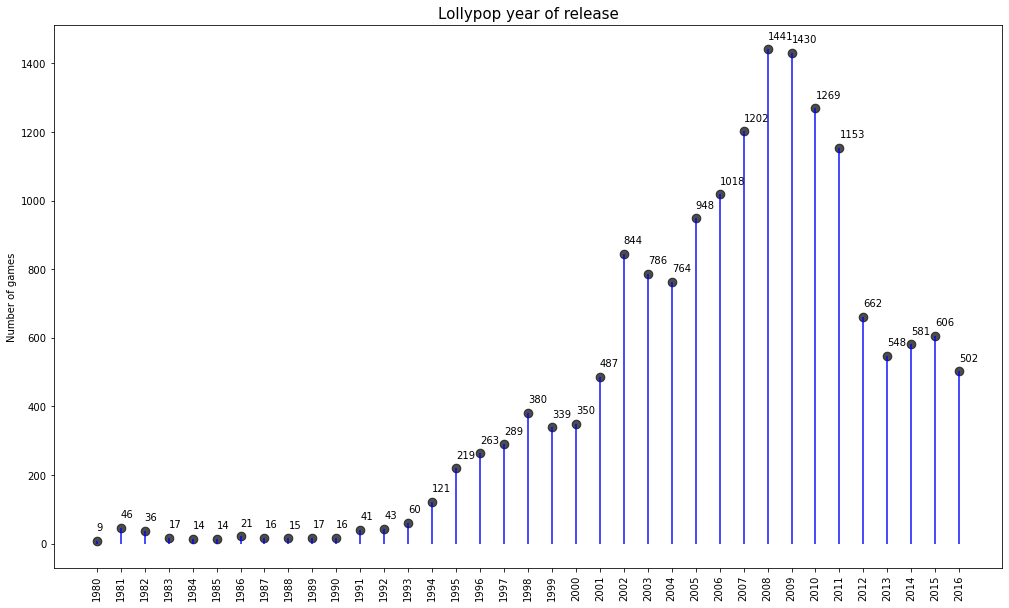

In [23]:
fig,ax=plt.subplots(figsize=(17,10))
ax.vlines(x=year_df.year_of_release, ymin=0, ymax=year_df.name, color='blue', alpha=0.7, linewidth=2)
ax.scatter(x=year_df.year_of_release, y=year_df.name, s=75, color='black', alpha=0.7)

ax.set_title('Lollypop year of release', fontdict={'size': 15})
ax.set_ylabel('Number of games')
ax.set_xticks(year_df.year_of_release)
ax.set_xticklabels(year_df.year_of_release, rotation=90)

for row in year_df.itertuples():
    ax.text(row.year_of_release, row.name+30, s=round(row.name,2))

 As we can see in the graph the most relevant years to work with is 2007 - 2011, the years before 1998 are irelevant.

## Look at how sales varied from platform to platform.

In [24]:
platform_df = clean_data[['platform','total_sales']].groupby(['platform']).sum().sort_values(by='total_sales').reset_index()

# calculating the z score, how many std the platform sales are far from the mean of total sales
platform_df['sales_z'] = (platform_df['total_sales'] - platform_df['total_sales'].mean()) / platform_df['total_sales'].std()
platform_df

,platform,total_sales,sales_z
0,PCFX,0.03,-0.825614
1,GG,0.04,-0.825586
2,3DO,0.10,-0.825413
3,TG16,0.16,-0.825241
4,WS,1.42,-0.821623
5,NG,1.44,-0.821565
6,SCD,1.86,-0.820359
7,DC,15.95,-0.779896
8,GEN,28.35,-0.744287
9,SAT,33.59,-0.729239


In [25]:
# adding a color column for the ploting (negetive z = red, positive z = green)
platform_df['color'] = ['red' if x<0 else 'green' for x in platform_df['sales_z']]
platform_df

,platform,total_sales,sales_z,color
0,PCFX,0.03,-0.825614,red
1,GG,0.04,-0.825586,red
2,3DO,0.10,-0.825413,red
3,TG16,0.16,-0.825241,red
4,WS,1.42,-0.821623,red
5,NG,1.44,-0.821565,red
6,SCD,1.86,-0.820359,red
7,DC,15.95,-0.779896,red
8,GEN,28.35,-0.744287,red
9,SAT,33.59,-0.729239,red


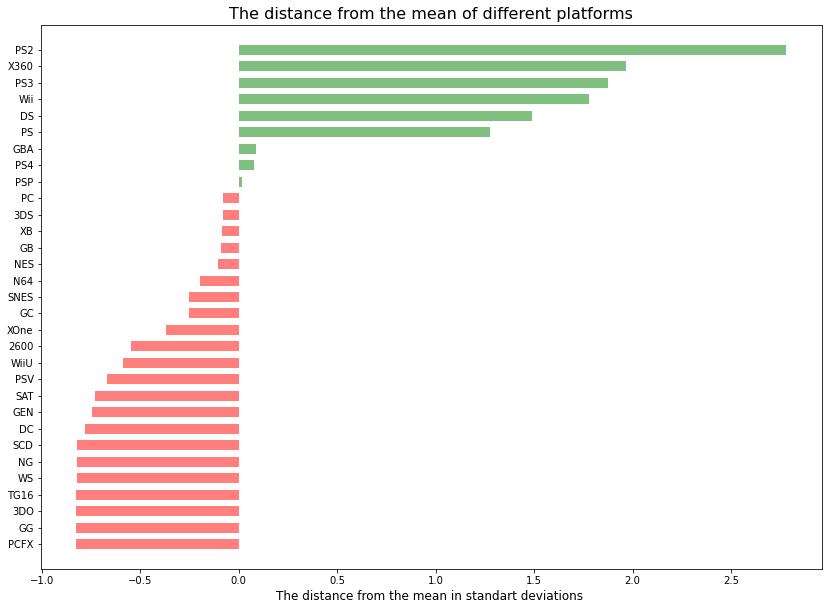

In [26]:
plt.figure(figsize=(14,10))
plt.hlines(y=platform_df.platform, xmax=platform_df.sales_z,xmin=0,color=platform_df.color,alpha=0.5,linewidth=10)
plt.xlabel('The distance from the mean in standart deviations ', size=12)
plt.title('The distance from the mean of different platforms', size=16)
plt.show()

As we can see from the graph:
* There are some platforms that are close to the mean total slaes


* Some platforms that are somewhat lower than the mean


* And the leading platforms in sales (ps2, x360, ps3, wii, DS, PS) that are a lot higher than the total sales mean.

## Choose the platforms with the greatest total sales and build a distribution based on data for each year

In [27]:
# creating data fram from year 1996
good_year_data = clean_data[clean_data.year_of_release >= 1996]

In [28]:
# creating data frame for the best selling platform from the year 2000
good_plat_data = good_year_data.query('platform == ["PS2", "X360", "PS3", "DS", "Wii", "PS"]').reset_index()

In [29]:
good_plat_data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
2,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
3,6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
4,7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [30]:
# pivot table of total sales of best selling platforms by year
plat_pivot = good_plat_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
plat_pivot

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1996,0.00,94.70,0.00,0.00,0.00,0.00
1997,0.00,136.17,0.00,0.00,0.00,0.00
1998,0.00,169.49,0.00,0.00,0.00,0.00
1999,0.00,144.53,0.00,0.00,0.00,0.00
2000,0.00,96.37,39.17,0.00,0.00,0.00
2001,0.00,35.59,166.43,0.48,0.00,0.00
2002,0.00,6.67,208.36,0.00,0.00,0.00
2003,0.00,2.07,194.00,0.00,0.00,0.00
2004,17.27,0.00,211.81,0.00,0.00,0.00


In [31]:
plat_pivot.describe()

platform,DS,PS,PS2,PS3,Wii,X360
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,38.298095,32.647143,59.388571,44.532857,43.014762,46.029048
std,57.447685,57.160381,79.753022,58.277639,70.528435,59.166236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5.640000,3.600000,0.180000,9.220000
75%,85.350000,35.590000,103.990000,108.280000,59.790000,95.410000
max,147.230000,169.490000,211.810000,157.980000,206.970000,170.550000


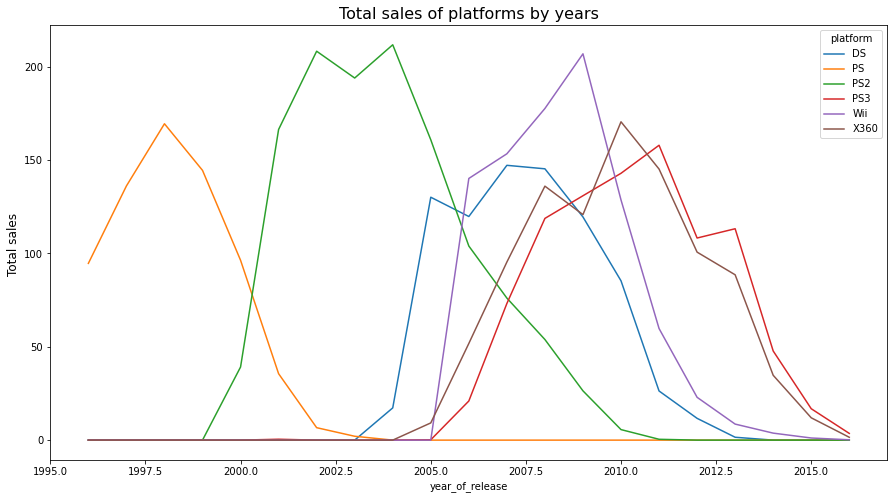

In [32]:
plat_pivot.plot(figsize=(15,8))
plt.ylabel('Total sales ', size=12)
plt.title('Total sales of platforms by years', size=16)
plt.show()

## Find platforms that used to be popular but now have zero sales. How long does it generally take for new platforms to appear and old ones to fade?

In [33]:
# pivot table of total sales of all platforms by year
plat_pivot_all = good_year_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)

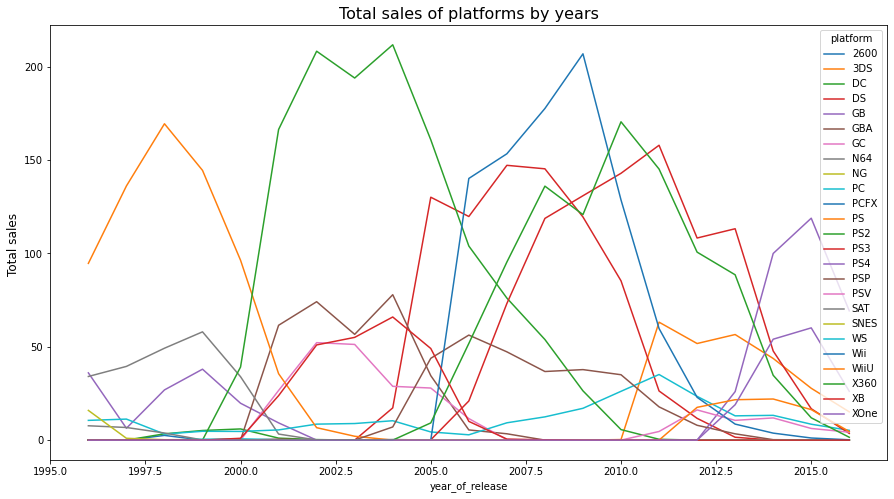

In [34]:
#ploting
plat_pivot_all.plot(figsize=(15,8))
plt.ylabel('Total sales ', size=12)
plt.title('Total sales of platforms by years', size=16)
plt.show()

In [35]:
# creating table of life span for all platforms
plat_group_life = good_year_data.groupby(['platform'])['year_of_release'].agg(['min','max']).reset_index()
plat_group_life['life'] = plat_group_life['max']-plat_group_life['min']
plat_group_life


,platform,min,max,life
0,2600,1998,1998,0
1,3DS,2003,2016,13
2,DC,1998,2008,10
3,DS,2004,2013,9
4,GB,1996,2001,5
5,GBA,2000,2007,7
6,GC,2001,2007,6
7,N64,1996,2004,8
8,NG,1996,1996,0
9,PC,1996,2016,20


In [36]:
print('The mean life span of the platforms is: {}'.format(plat_group_life['life'].mean()))

The mean life span of the platforms is: 6.96


## Taking all years into acount

In [37]:
all_year_data = clean_data[clean_data.year_of_release >= 1980]

In [38]:
# pivot table of total sales of all platforms by year
plat_pivot_all = all_year_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)

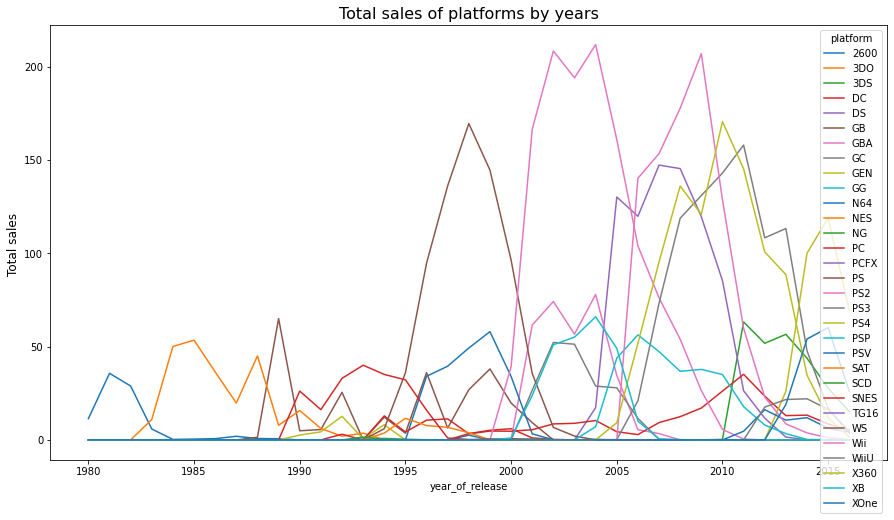

In [39]:
#ploting
plat_pivot_all.plot(figsize=(15,8))
plt.ylabel('Total sales ', size=12)
plt.title('Total sales of platforms by years', size=16)
plt.show()

In [40]:
# creating data fram from year 1996
all_year_data = clean_data[clean_data.year_of_release >= 1980]

In [41]:
# creating table of life span for all platforms in all years
plat_group_life = all_year_data.groupby(['platform'])['year_of_release'].agg(['min','max']).reset_index()
plat_group_life['life'] = plat_group_life['max']-plat_group_life['min']
plat_group_life


,platform,min,max,life
0,2600,1980,1998,18
1,3DO,1994,1995,1
2,3DS,2003,2016,13
3,DC,1998,2008,10
4,DS,1985,2013,28
5,GB,1988,2001,13
6,GBA,2000,2007,7
7,GC,2001,2007,6
8,GEN,1990,1994,4
9,GG,1992,1992,0


In [42]:
print('The mean life span of the platforms is: {}'.format(plat_group_life['life'].mean()))

The mean life span of the platforms is: 8.387096774193548


## Conclusion:
* There are a lot of platform that had great sales and now are dead (SAT, DS, XB, PS, PS2...) 
* the life-span of the good platforms are usualy around 7 years with some exceptions)

* I will minimise the years some more because of the life span and the total sales, i want it to be relavent to 2017

In [43]:
final_good_year_data = clean_data[clean_data.year_of_release >= 2008]

## Which platforms are leading in sales? Which ones are growing or shrinking? Select several potentially profitable platforms

In [44]:
#pivot table for the above data
final_plat_pivot_all = final_good_year_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
final_plat_pivot_all

platform,3DS,DC,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,
2008,0.00,0.04,145.36,12.46,53.90,118.79,0.00,36.76,0.00,177.68,0.00,136.07,0.18,0.00
2009,0.00,0.00,119.56,17.05,26.40,130.93,0.00,37.78,0.00,206.97,0.00,120.82,0.00,0.00
2010,0.30,0.00,85.35,26.15,5.64,142.96,0.00,35.04,0.00,128.67,0.00,170.55,0.00,0.00
2011,63.20,0.00,26.33,35.16,0.45,157.98,0.00,17.82,4.63,59.79,0.00,145.23,0.00,0.00
2012,51.76,0.00,11.67,23.45,0.00,108.28,0.00,7.95,16.19,22.94,17.56,100.72,0.00,0.00
2013,56.57,0.00,1.54,13.01,0.00,113.25,25.99,3.38,10.59,8.59,21.65,88.58,0.00,18.96
2014,43.76,0.00,0.00,13.28,0.00,47.76,100.00,0.24,11.90,3.75,22.03,34.74,0.00,54.07
2015,27.78,0.00,0.00,8.52,0.00,16.82,118.90,0.12,6.25,1.14,16.35,11.96,0.00,60.14
2016,15.14,0.00,0.00,5.25,0.00,3.60,69.25,0.00,4.25,0.18,4.60,1.52,0.00,26.15


In [45]:
# creating table of calculated growth or shrinkage in sales
dynamics = (final_plat_pivot_all-final_plat_pivot_all.shift(+1)).T
dynamics

year_of_release,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,
3DS,NaN,0.00,0.30,62.90,-11.44,4.81,-12.81,-15.98,-12.64
DC,NaN,-0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DS,NaN,-25.80,-34.21,-59.02,-14.66,-10.13,-1.54,0.00,0.00
PC,NaN,4.59,9.10,9.01,-11.71,-10.44,0.27,-4.76,-3.27
PS2,NaN,-27.50,-20.76,-5.19,-0.45,0.00,0.00,0.00,0.00
PS3,NaN,12.14,12.03,15.02,-49.70,4.97,-65.49,-30.94,-13.22
PS4,NaN,0.00,0.00,0.00,0.00,25.99,74.01,18.90,-49.65
PSP,NaN,1.02,-2.74,-17.22,-9.87,-4.57,-3.14,-0.12,-0.12
PSV,NaN,0.00,0.00,4.63,11.56,-5.60,1.31,-5.65,-2.00


<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

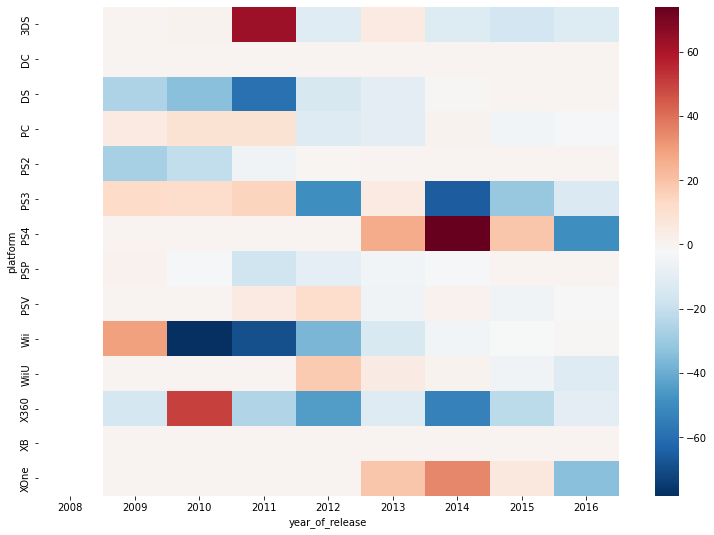

In [46]:
plt.figure(figsize=(13,9))
sns.heatmap(dynamics,cmap='RdBu_r')

## conclusion
* PS4, Xone, PC, are good platform to invest because they still make good revenue even thogh they shrinking.
* It seems that the era of new generation platforms is upoon us. all the new platforms sales are over the top and shrinking.

## Focusing only on the last years

In [47]:
recent_good_year_data = clean_data[clean_data.year_of_release >= 2014]

In [48]:
#pivot table for the above data
final_plat_pivot_all = recent_good_year_data.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum', fill_value=0)
final_plat_pivot_all

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


In [49]:
# creating table of calculated growth or shrinkage in sales
dynamics2 = (final_plat_pivot_all-final_plat_pivot_all.shift(+1)).T
dynamics2

year_of_release,2014,2015,2016
platform,,,
3DS,NaN,-15.98,-12.64
PC,NaN,-4.76,-3.27
PS3,NaN,-30.94,-13.22
PS4,NaN,18.90,-49.65
PSP,NaN,-0.12,-0.12
PSV,NaN,-5.65,-2.00
Wii,NaN,-2.61,-0.96
WiiU,NaN,-5.68,-11.75
X360,NaN,-22.78,-10.44


<AxesSubplot:xlabel='year_of_release', ylabel='platform'>

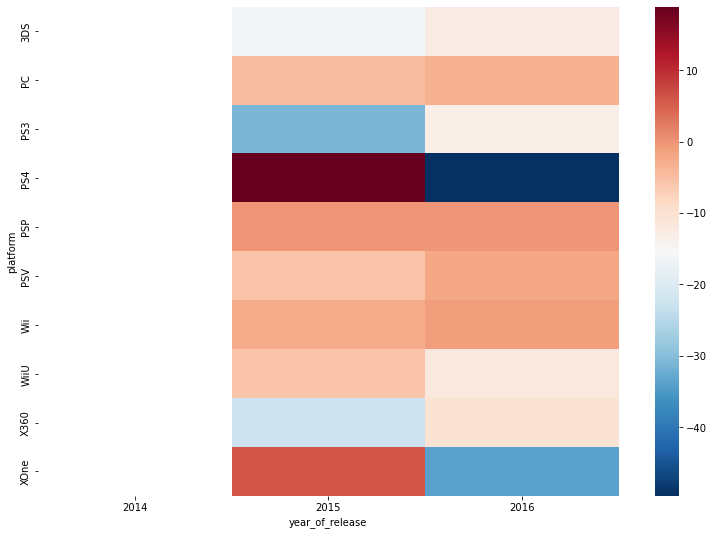

In [50]:
plt.figure(figsize=(13,9))
sns.heatmap(dynamics2,cmap='RdBu_r')

## 	Build a box plot for the global sales of all games, broken down by platform. Are the differences in sales significant? What about average sales on various platforms? Describe your findings.

In [51]:
good_data = good_year_data.query('platform != ["PCFX", "NG","2600"]').reset_index()

In [52]:
grouped = good_data.groupby(['platform','name'])['total_sales'].sum().reset_index()
grouped

,platform,name,total_sales
0,3DS,Beyblade Burst,0.03
1,3DS,Fire Emblem Fates,1.67
2,3DS,Frozen: Olaf's Quest,0.59
3,3DS,Haikyu!! Cross Team Match!,0.04
4,3DS,12-Sai. Honto no Kimochi,0.07
...,...,...,...
15849,XOne,XCOM 2,0.04
15850,XOne,ZombiU,0.01
15851,XOne,Zombie Army Trilogy,0.11
15852,XOne,Zoo Tycoon (2013),0.36


In [53]:
order = grouped.groupby(['platform'])['total_sales'].sum().reset_index().sort_values(by='total_sales')['platform']
order

16      WS
1       DC
15    SNES
14     SAT
13     PSV
18    WiiU
3       GB
21    XOne
5       GC
6      N64
7       PC
20      XB
0      3DS
12     PSP
4      GBA
11     PS4
8       PS
2       DS
17     Wii
10     PS3
19    X360
9      PS2
Name: platform, dtype: object

[Text(0.5, 1.0, 'Box plot of games total sales by platform')]

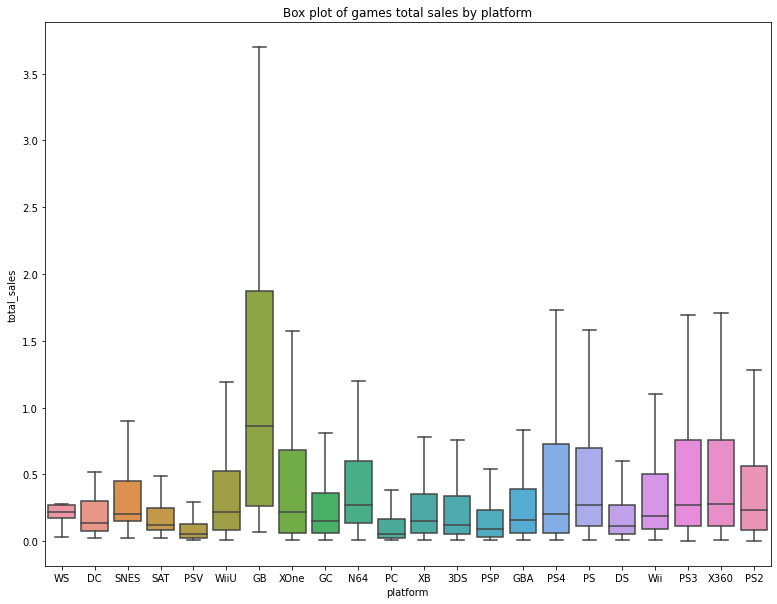

In [54]:
plt.figure(figsize=(13,10))
sns.boxplot(x='platform', y='total_sales', data=grouped, order=order, showfliers = False)  .set(title='Box plot of games total sales by platform')

## findings:
* There is no significant differnce between the top salling platforms


* The only significant diffrence is between GB game selling and the rest probably because its realy old and still kicking


* Another significant diffrence is that pc is selling les games than the other platforms, make sense because pc has more uses than gaming.

##  Take a look at how user and professional reviews affect sales for one popular platform (you choose). Build a scatter plot and calculate the correlation between reviews and sales. Draw conclusions.

In [55]:
ps4_df = good_data[(good_data['platform']=='PS4')&(good_data.user_score!='tbd')][['total_sales', 'user_score','critic_score']].dropna().astype(float)
ps4_df

,total_sales,user_score,critic_score
36,12.62,8.3,97.0
67,8.58,4.3,82.0
81,7.66,5.7,83.0
83,7.60,5.0,85.0
93,7.17,6.5,87.0
...,...,...,...
15631,0.01,2.3,42.0
15644,0.01,6.8,70.0
15645,0.01,7.5,69.0
15670,0.01,7.9,61.0


In [56]:
ps4_df[ps4_df.user_score == 'tbd']

,total_sales,user_score,critic_score


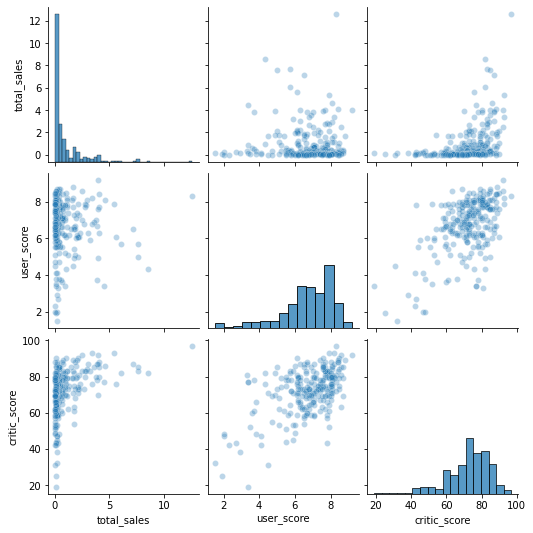

In [57]:
sns.pairplot(ps4_df, plot_kws={'alpha':0.3})

In [58]:
ps4_df.corr()

,total_sales,user_score,critic_score
total_sales,1.000000,-0.033625,0.405895
user_score,-0.033625,1.000000,0.557654
critic_score,0.405895,0.557654,1.000000


## conclusion
* There isnt strong correlation between critics and total sales.
* There is a week corelation between the two types of critics.

## Checking correlation in other succesful platforms

In [59]:
#removing tbd for the analysis
no_tbd=good_data[good_data.user_score!='tbd']

In [60]:
# function to check correlation between user_score and total sales 
def score_effect(platform,score_type):
    data=no_tbd[no_tbd['platform']==platform][['total_sales', score_type]].dropna().astype(float)
    data.plot.scatter(x=score_type, y='total_sales', title=platform + ' ' + score_type + "  X total sales plot");
    
    corr = data.corr()
    
    if corr.loc[score_type,'total_sales'] > 0.6:
        result = 'There is a correlation in: ' + platform + ' between ' + score_type + ' and total sales'
    else:
        result = 'No correlatin in: ' + platform + ' between ' + score_type + ' and total sales'
    print(result)
        

In [61]:
platform = ["Wii", "XOne", 'X360', 'PS2']
col = ['user_score', 'critic_score']

No correlatin in: Wii between user_score and total sales
No correlatin in: Wii between critic_score and total sales
No correlatin in: XOne between user_score and total sales
No correlatin in: XOne between critic_score and total sales
No correlatin in: X360 between user_score and total sales
No correlatin in: X360 between critic_score and total sales
No correlatin in: PS2 between user_score and total sales
No correlatin in: PS2 between critic_score and total sales


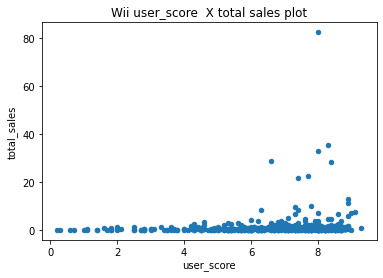

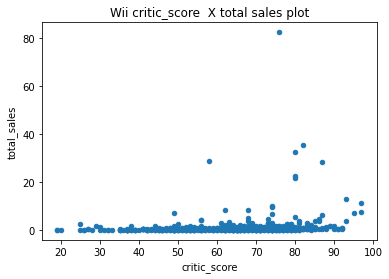

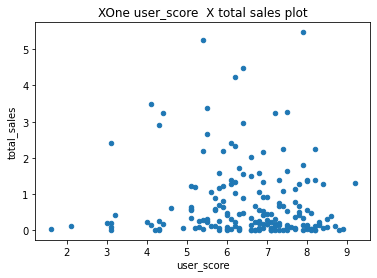

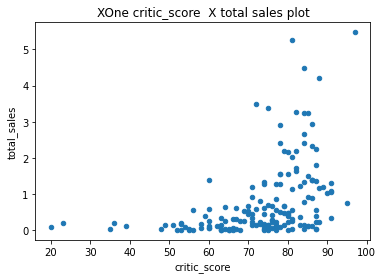

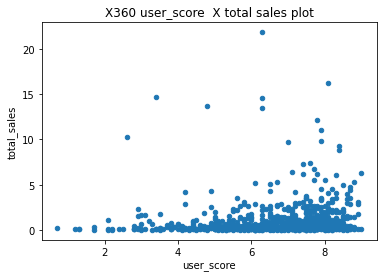

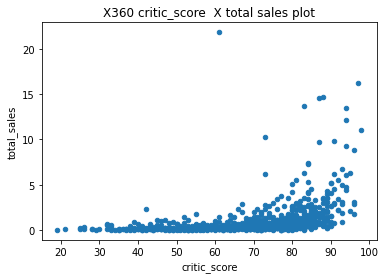

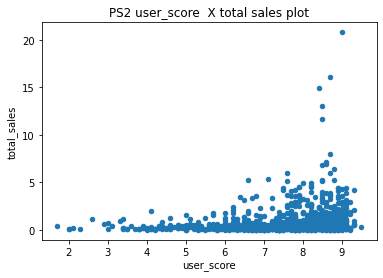

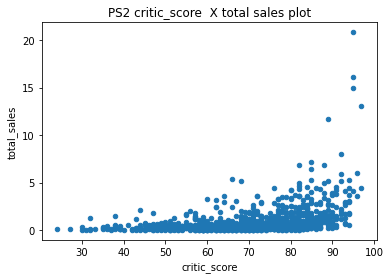

In [62]:
for i in platform:
    for x in col:
        score_effect(i,x)

## conclusion
* There is no correlation between critics and revenue!

## 	Take a look at the general distribution of games by genre. 

In [63]:
game_genre = good_data.groupby(['name','genre'])['total_sales'].sum().reset_index()
game_genre


,name,genre,total_sales
0,Beyblade Burst,Role-Playing,0.03
1,Fire Emblem Fates,Role-Playing,1.67
2,Frozen: Olaf's Quest,Platform,1.10
3,Haikyu!! Cross Team Match!,Adventure,0.04
4,Tales of Xillia 2,Role-Playing,0.84
...,...,...,...
10821,thinkSMART FAMILY!,Misc,0.03
10822,thinkSMART: Chess for Kids,Misc,0.01
10823,uDraw Studio,Misc,2.42
10824,uDraw Studio: Instant Artist,Misc,0.19


In [64]:
genre_pivot = game_genre.pivot_table(index='genre', values='total_sales', aggfunc='sum' ).sort_values(by='total_sales', ascending=False).reset_index()
genre_pivot

,genre,total_sales
0,Action,1660.60
1,Sports,1267.38
2,Shooter,969.92
3,Role-Playing,874.86
4,Misc,771.39
5,Racing,688.65
6,Platform,595.62
7,Fighting,388.56
8,Simulation,375.45
9,Adventure,209.56


Text(0.5, 1.0, 'Total sales by genre')

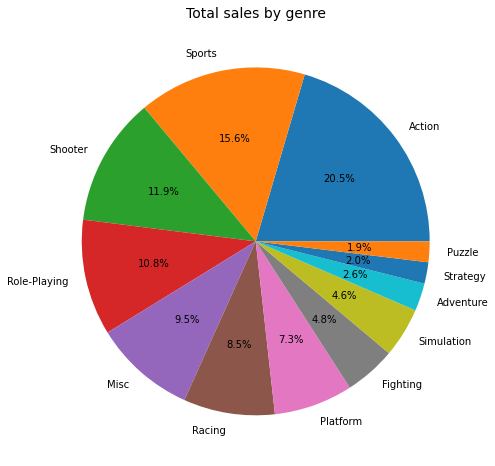

In [65]:
ax = plt.subplots(figsize=[15,8])
labels = genre_pivot.genre
plt.pie(x='total_sales', autopct="%.1f%%", labels=labels, data=genre_pivot)
plt.title('Total sales by genre', fontsize=14)


## Conclusion
* The most profitable genres are Action, Sports and shooter, action is by far the most profitable genre


* Puzzels and starategy are the least profitable.


* What does it says about the gaming society???...

# Create a user profile for each region
## For each region (NA, EU, JP), determine:
* The top five platforms. Describe variations in their market shares from region to region.

* The top five genres. Explain the difference.

* Do ESRB ratings affect sales in individual regions?


In [66]:
clean_data.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54


In [67]:
def top5(where, by):
    data = good_data.groupby([by])[where].sum().reset_index().sort_values(by=where, ascending=False).head()
    ax = plt.subplots(figsize=[11,5])
    labels = data[by]
    plt.pie(x=where, autopct="%.1f%%", labels=labels, data=data)
    plt.title(f'{where} by {by}', fontsize=14)
    print(f'Top 5 {by}s in {where} are: {data[by].tolist()}\n ')

In [68]:
by = ['platform', 'genre', 'rating']
where = ['na_sales', 'eu_sales', 'jp_sales','other_sales']

Top 5 platforms in na_sales are: ['X360', 'PS2', 'Wii', 'PS3', 'DS']
 
Top 5 genres in na_sales are: ['Action', 'Sports', 'Shooter', 'Misc', 'Racing']
 
Top 5 ratings in na_sales are: ['E', 'T', 'M', 'E10+', 'K-A']
 
Top 5 platforms in eu_sales are: ['PS2', 'PS3', 'X360', 'Wii', 'PS']
 
Top 5 genres in eu_sales are: ['Action', 'Sports', 'Shooter', 'Racing', 'Misc']
 
Top 5 ratings in eu_sales are: ['E', 'M', 'T', 'E10+', 'AO']
 
Top 5 platforms in jp_sales are: ['DS', 'PS2', 'PS', '3DS', 'PS3']
 
Top 5 genres in jp_sales are: ['Role-Playing', 'Action', 'Sports', 'Misc', 'Platform']
 
Top 5 ratings in jp_sales are: ['E', 'T', 'M', 'E10+', 'K-A']
 
Top 5 platforms in other_sales are: ['PS2', 'PS3', 'X360', 'Wii', 'DS']
 
Top 5 genres in other_sales are: ['Action', 'Sports', 'Shooter', 'Racing', 'Misc']
 
Top 5 ratings in other_sales are: ['E', 'M', 'T', 'E10+', 'EC']
 


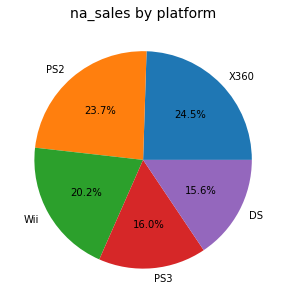

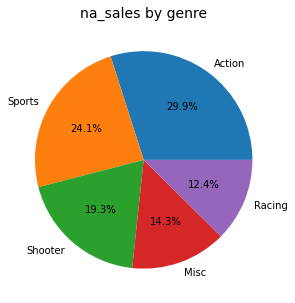

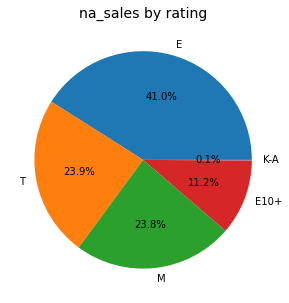

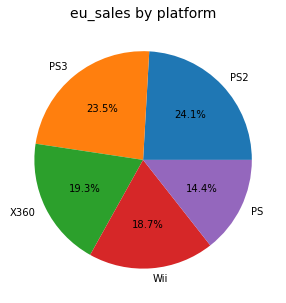

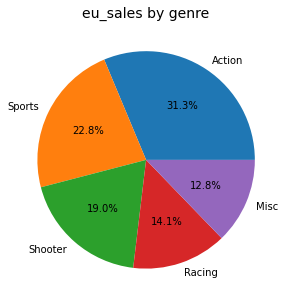

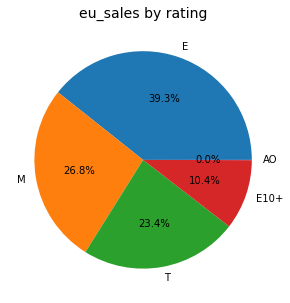

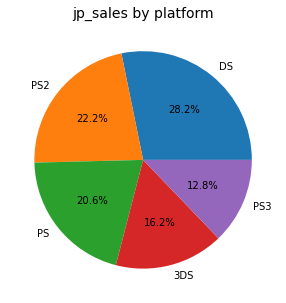

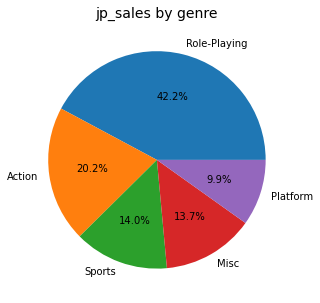

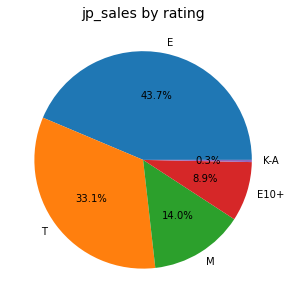

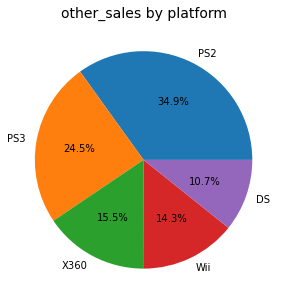

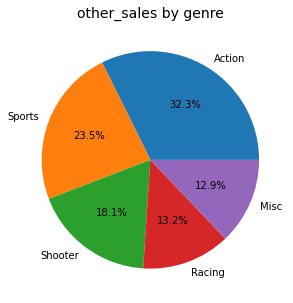

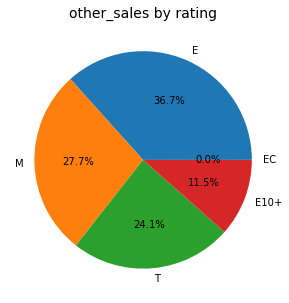

In [69]:
for i in where:
    for x in by:
        top5(i,x)

## platforms in regions:
* In north america the no.1 is xbox360 (wich is american) and then ps2 and Wii
* in japan its DS Ps and PS2
* in europe ps2 ps3 xbox 360

## genre in regions:
* In all the regions exept japan the top genres are action, sports, shooter
* in Japan the top genres are role playing, action, sports
* I am with Japan :)

## rating in regions:
* In all the regions the top three ratings are the same
* It seems the the rating do affect the sales


# Test the following hypotheses:

## Average user ratings of the Xbox One and PC platforms are the same.

* H0 = user ratings of the Xbox One and PC platforms are the same
* H1 = user ratings of the Xbox One and PC platforms are differnt
* alpha = 0.05
* I chose significant level of 95%.

In [70]:
# xbox sample
xbox=good_data[(good_data.platform=='XB')&(good_data.user_score.notna())&(good_data.user_score!='tbd')]['user_score'].astype(float)
xbox

68       8.2
116      8.6
418      8.5
457      8.7
511      8.5
        ... 
15189    6.0
15307    2.7
15344    7.3
15353    3.0
15601    7.0
Name: user_score, Length: 581, dtype: float64

In [71]:
#pc sample
pc=good_data[(good_data.platform=='PC')&(good_data.user_score.notna())&(good_data.user_score!='tbd')]['user_score'].astype(float)
pc

75       7.6
124      7.3
173      4.0
197      8.2
255      9.1
        ... 
15824    8.1
15835    7.6
15839    5.8
15845    7.2
15848    5.8
Name: user_score, Length: 763, dtype: float64

In [72]:
#checking equality of varience with levenes test
stats.levene(xbox, pc, center='mean')

LeveneResult(statistic=4.061530468565258, pvalue=0.044069774399291925)

* Levens test pvalue is `lower` than alpha, we can reject the null hypotesis.
* The variences are equal, 'equal_var =`False`'

In [73]:
# testing hypothesis
alpha = 0.05
result = stats.ttest_ind(xbox,
                        pc, equal_var = False)
print('p-value: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('We reject the null hypothesis - there is a significat difference between Xbox and PC avarage user ratings')
else:
    print("We can't reject the null hypothesis")

# mean
xbox_mean = xbox.mean()
pc_mean = pc.mean()
print('xbox mean:{}'.format(xbox_mean))
print('pc mean:{}'.format(pc_mean))

p-value: 1.432636419662159e-07
We reject the null hypothesis - there is a significat difference between Xbox and PC avarage user ratings
xbox mean:7.511187607573158
pc mean:7.073918741808665


## conclusion: 
Average user score for Xbox and PC are differnt - Xbox user score mean is higher. 

## Check if average user ratings for the Action and Sports genres are different.

In [74]:
action=good_data[(good_data.genre=='Action')&(good_data.user_score.notna())&(good_data.user_score!='tbd')]['user_score'].astype(float)
action

13       8.2
14       9.0
17       8.1
18       8.7
32       8.5
        ... 
15796    8.5
15798    5.1
15804    6.7
15807    2.4
15835    7.6
Name: user_score, Length: 1820, dtype: float64

In [75]:
sports=good_data[(good_data.genre=='Sports')&(good_data.user_score.notna())&(good_data.user_score!='tbd')]['user_score'].astype(float)
sports

0        8.0
2        8.0
10       7.7
12       7.4
67       4.3
        ... 
15596    4.5
15663    1.4
15672    6.9
15690    9.5
15787    6.6
Name: user_score, Length: 1098, dtype: float64

In [76]:
#checking equality of varience with levenes test
stats.levene(action, sports, center='mean')

LeveneResult(statistic=21.543129658151305, pvalue=3.6123750552485777e-06)

* Levens test pvalue is lower than alpha, we reject the null hypotesis.
* The variences are not equal, 'equal_var =False'

In [77]:
# testing hypothesis
alpha = 0.05
result = stats.ttest_ind(action,
                        sports, equal_var = False)
print('p-value: {}'.format(result.pvalue))

if result.pvalue < alpha:
    print('We reject the null hypothesis - there is a significat difference between Action and Sports genres avarage user ratings')
else:
    print("We can't reject the null hypothesis")

# mean
action_mean = action.mean()
sports_mean = sports.mean()
print('action mean:{}'.format(action_mean))
print('sports mean:{}'.format(sports_mean))

p-value: 0.08991887133875968
We can't reject the null hypothesis
action mean:7.05648351648351
sports mean:6.9563752276867055


## Conclusion: Average user ratings for the Action and Sports genres are not  statisticaly different.

## explanation
* The null hypothesis is always about nothing changes or there is no differnece
* if p-value is smaller than alpha we can reject the null hypothsis
* significance level of 95% is very common in science, less than it is not very acurate and higher can be too strict.

#  General conclusion
* To plan 2017 campain we need to focus on 'PS4', 'PS3', 'X360', 'Wii' platforms


* We dont care about critic or users score.


* The best geners to focus on are : Action, Sports and Shooter (RPG in japan).


* we should anticipate new generation platforms because the current platforms games sales are already declining.

